In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import wave
from scipy.io.wavfile import read
from sklearn.model_selection import train_test_split
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
import sounddevice as sd
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import  Conv1D,  GRU, Dropout, Input, Dense, Conv2D, Reshape, MaxPooling2D
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from scipy import linalg
random.seed(111)
fs = 16000
Keyword_path = "/home/avatar/avatar_project/keyword_sound"
Noise_path =  "/home/avatar/avatar_project/background_sound"

Val_path_pos = "/home/avatar/avatar_project/validation_data/positives"
Val_path_neg = "/home/avatar/avatar_project/validation_data/negatives"

2023-01-10 12:12:36.723544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 12:12:36.841667: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-10 12:12:36.866129: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-10 12:12:37.348093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
def spec_augment(spec: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.10, time_masking_max_percentage=0.2):

    spec = spec.copy()
    for i in range(num_mask):
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0
    
    return spec


In [3]:
keyword_data = []
noise_data = []
test_pos = []
test_neg = []
val_pos = []
val_neg = []
sample_rate = 16000
keyword_data_aug = []
noise_data_aug = []

ebin_augment = []
ebin = []

keyword_audio = []
noise_audio = []

for keyword in os.listdir(Keyword_path):
    audio, fs = librosa.load(os.path.join(Keyword_path, keyword), sr=16000)
    keyword_audio.append(audio)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    keyword_data.append(mel_spec_db_norm) 
    ebin.append(mel_spec_db)
    mel_spec_db = librosa.power_to_db(spec_augment(mel_spec), ref=np.max).T
    ebin_augment.append(mel_spec_db)
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    keyword_data_aug.append(mel_spec_db_norm) 


    
for keyword in os.listdir(Val_path_pos):
    audio, fs = librosa.load(os.path.join(Val_path_pos, keyword), sr=16000)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    val_pos.append(mel_spec_db_norm) 
    
    
    

for noise in os.listdir(Noise_path):
    audio, fs = librosa.load(os.path.join(Noise_path, noise), sr=16000)
    noise_audio.append(audio)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    noise_data.append(mel_spec_db_norm)
    
    mel_spec_db = librosa.power_to_db(spec_augment(mel_spec), ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    noise_data_aug.append(mel_spec_db_norm) 
 


    
for noise in os.listdir(Val_path_neg):
    audio, fs = librosa.load(os.path.join(Val_path_neg, noise), sr=16000)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    val_neg.append(mel_spec_db_norm) 

In [4]:
def time_shift(audio): 
    return np.roll(audio,int(sample_rate/(random.randint(2,10)))) #randint means that roll is done with freqs 1600 and 3200



for audio_first in keyword_audio[::10]:
    for audio_second in keyword_audio[::10]: 
        audio_shifted = np.add(audio_first, time_shift(audio_second)*random.uniform(0.6, 0.9))
        
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
        mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        keyword_data.append(mel_spec_db_norm) 
        
for audio_first in noise_audio[::10]:
    for audio_second in noise_audio[::10]: 
        audio_shifted = np.add(audio_first, time_shift(audio_second)*random.uniform(0.6, 0.9))
        
        mel_spec = librosa.feature.melspectrogram(y=audio_shifted, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
        mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        noise_data.append(mel_spec_db_norm)
        

keyword_data = keyword_data + keyword_data_aug
noise_data = noise_data + noise_data_aug

(301, 48)


/tmp/ipykernel_135866/3448456333.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)
/tmp/ipykernel_135866/3448456333.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)


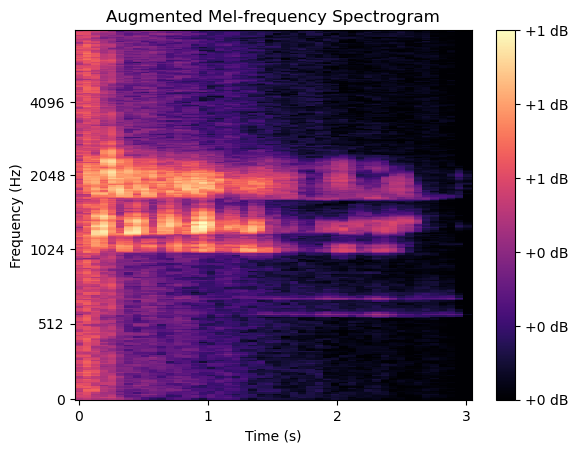

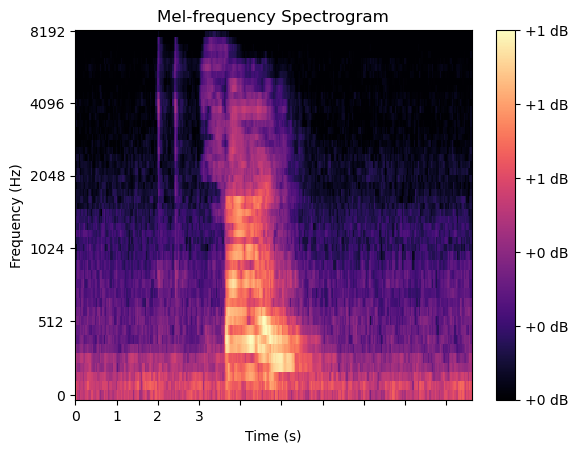

In [5]:
import librosa.display

fig, ax = plt.subplots()
x = ["","0", "1", "2", "3"]
print(keyword_data[17].shape)
img = librosa.display.specshow(keyword_data[17], x_axis='time',
y_axis='mel', sr=16000, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set_xticklabels(x)
ax.set(title='Augmented Mel-frequency Spectrogram')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.savefig('augmented_mel_spec.png')
#Let us take a look at one of the true positive and false positive samples Female voice test set. 

fig, ax = plt.subplots()
x = ["","0", "1", "2", "3"]

img = librosa.display.specshow(noise_data[0].T, x_axis='time',
y_axis='mel', sr=16000, fmax=8000, ax=ax)

fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set_xticklabels(x)
ax.set(title='Mel-frequency Spectrogram')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.savefig('mel_spec.png')

In [6]:
print(np.shape(keyword_data))
print(np.shape(noise_data))
print(np.shape(val_pos))
print(np.shape(val_neg))

keyword_data = np.squeeze(keyword_data)
noise_data = np.squeeze(noise_data)
val_pos = np.squeeze(val_pos)
val_neg = np.squeeze(val_neg)

keyword_labels = np.ones(keyword_data.shape[0])
val_pos_labels = np.ones(val_pos.shape[0])

noise_labels = 0*np.ones(noise_data.shape[0])
val_neg_labels = 0*np.ones(val_neg.shape[0])

X_train = np.concatenate((keyword_data, noise_data), axis=0)
y_train  = np.concatenate((keyword_labels, noise_labels), axis=0)

X_val = np.concatenate((val_pos, val_neg), axis=0)
y_val = np.concatenate((val_pos_labels, val_neg_labels), axis=0)

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_val = tf.keras.utils.to_categorical(y_val, 2)

(3149, 301, 48)
(3149, 301, 48)
(190, 301, 48)
(190, 301, 48)


In [7]:
print(keyword_data.shape[1])
print(keyword_data.shape[2])

301
48


In [8]:
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

num_units = 48
dropout_ratio = 0.3
checkpoint_filepath = '/home/avatar/avatar_project/wake_word_model'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=120, mode='min'),
                tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, 
                monitor='val_loss', mode='max', save_best_only=True),
]

model = Sequential([
    Input(shape=(keyword_data.shape[1], keyword_data.shape[2])),
    Conv1D(num_units,3,padding="same",activation='relu',name='layer1'),
    Dropout(dropout_ratio),
    Conv1D(num_units,3,padding="same",activation='relu',name='layer2'),
    Dropout(dropout_ratio),
    GRU(num_units,name='RNN_1',return_sequences=False),
    Dense(2, activation='softmax', name='dense_a'),
])

model.compile(loss='BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv1D)             (None, 301, 48)           6960      
                                                                 
 dropout (Dropout)           (None, 301, 48)           0         
                                                                 
 layer2 (Conv1D)             (None, 301, 48)           6960      
                                                                 
 dropout_1 (Dropout)         (None, 301, 48)           0         
                                                                 
 RNN_1 (GRU)                 (None, 48)                14112     
                                                                 
 dense_a (Dense)             (None, 2)                 98        


2023-01-10 12:13:51.390741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 12:13:51.757604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7148 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:65:00.0, compute capability: 7.0


                                                                 
Total params: 28,130
Trainable params: 28,130
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, callbacks=my_callbacks, 
                    validation_data=(X_val, y_val))

Epoch 1/2000


2023-01-10 12:13:53.871457: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-01-10 12:13:54.164629: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


197/197 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.6116

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 9s 34ms/step - loss: 0.6633 - accuracy: 0.6116 - val_loss: 0.5956 - val_accuracy: 0.7079
Epoch 2/2000
197/197 [==============================] - 4s 21ms/step - loss: 0.6341 - accuracy: 0.6431 - val_loss: 0.5829 - val_accuracy: 0.7105
Epoch 3/2000
196/197 [============================>.] - ETA: 0s - loss: 0.6212 - accuracy: 0.6507

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 34ms/step - loss: 0.6207 - accuracy: 0.6515 - val_loss: 0.5985 - val_accuracy: 0.6974
Epoch 4/2000
196/197 [============================>.] - ETA: 0s - loss: 0.6069 - accuracy: 0.6657

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 6s 33ms/step - loss: 0.6069 - accuracy: 0.6654 - val_loss: 0.6066 - val_accuracy: 0.6684
Epoch 5/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.5898 - accuracy: 0.6888 - val_loss: 0.6013 - val_accuracy: 0.6842
Epoch 6/2000
196/197 [============================>.] - ETA: 0s - loss: 0.5702 - accuracy: 0.7034

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 34ms/step - loss: 0.5709 - accuracy: 0.7028 - val_loss: 0.6990 - val_accuracy: 0.5868
Epoch 7/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.5483 - accuracy: 0.7145 - val_loss: 0.6552 - val_accuracy: 0.6263
Epoch 8/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.5752 - accuracy: 0.7067 - val_loss: 0.6522 - val_accuracy: 0.6421
Epoch 9/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.5274 - accuracy: 0.7282 - val_loss: 0.6038 - val_accuracy: 0.6684
Epoch 10/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.5255 - accuracy: 0.7282 - val_loss: 0.6558 - val_accuracy: 0.6395
Epoch 11/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.4808 - accuracy: 0.7614 - val_loss: 0.6240 - val_accuracy: 0.6763
Epoch 12/2000
196/197 [============================>.] - ETA: 0s - loss: 0.4860 - accuracy: 0.7577

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 6s 33ms/step - loss: 0.4862 - accuracy: 0.7571 - val_loss: 0.7463 - val_accuracy: 0.6184
Epoch 13/2000
196/197 [============================>.] - ETA: 0s - loss: 0.4804 - accuracy: 0.7645

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 35ms/step - loss: 0.4800 - accuracy: 0.7650 - val_loss: 0.7642 - val_accuracy: 0.5737
Epoch 14/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.4479 - accuracy: 0.7841 - val_loss: 0.6410 - val_accuracy: 0.6763
Epoch 15/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.4199 - accuracy: 0.8104 - val_loss: 0.6816 - val_accuracy: 0.6474
Epoch 16/2000
196/197 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8356

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 6s 32ms/step - loss: 0.3769 - accuracy: 0.8347 - val_loss: 0.7924 - val_accuracy: 0.6105
Epoch 17/2000
197/197 [==============================] - 4s 21ms/step - loss: 0.4501 - accuracy: 0.7907 - val_loss: 0.6749 - val_accuracy: 0.6763
Epoch 18/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.3602 - accuracy: 0.8517 - val_loss: 0.6122 - val_accuracy: 0.7079
Epoch 19/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.3379 - accuracy: 0.8598 - val_loss: 0.6462 - val_accuracy: 0.7026
Epoch 20/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.3092 - accuracy: 0.8825 - val_loss: 0.6275 - val_accuracy: 0.7211
Epoch 21/2000
196/197 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8807

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 35ms/step - loss: 0.3002 - accuracy: 0.8808 - val_loss: 0.8024 - val_accuracy: 0.6658
Epoch 22/2000
197/197 [==============================] - 4s 21ms/step - loss: 0.2833 - accuracy: 0.8900 - val_loss: 0.6380 - val_accuracy: 0.7237
Epoch 23/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.2597 - accuracy: 0.9049 - val_loss: 0.6163 - val_accuracy: 0.7632
Epoch 24/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.2530 - accuracy: 0.9017 - val_loss: 0.5463 - val_accuracy: 0.7632
Epoch 25/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.2623 - accuracy: 0.9017 - val_loss: 0.6500 - val_accuracy: 0.7526
Epoch 26/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.2274 - accuracy: 0.9160 - val_loss: 0.6276 - val_accuracy: 0.7605
Epoch 27/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.2347 - accuracy: 0.9141 - val_loss: 0.5729 - val_accuracy:

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 6s 33ms/step - loss: 0.1544 - accuracy: 0.9408 - val_loss: 0.8094 - val_accuracy: 0.7263
Epoch 43/2000
197/197 [==============================] - 4s 21ms/step - loss: 0.1584 - accuracy: 0.9398 - val_loss: 0.6088 - val_accuracy: 0.7842
Epoch 44/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1498 - accuracy: 0.9386 - val_loss: 0.5451 - val_accuracy: 0.8026
Epoch 45/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1480 - accuracy: 0.9441 - val_loss: 0.6374 - val_accuracy: 0.7947
Epoch 46/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1541 - accuracy: 0.9384 - val_loss: 0.6681 - val_accuracy: 0.7868
Epoch 47/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1498 - accuracy: 0.9422 - val_loss: 0.7145 - val_accuracy: 0.7632
Epoch 48/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1548 - accuracy: 0.9414 - val_loss: 0.5756 - val_accuracy:

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 35ms/step - loss: 0.1454 - accuracy: 0.9416 - val_loss: 0.9830 - val_accuracy: 0.7342
Epoch 57/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1479 - accuracy: 0.9416 - val_loss: 0.5862 - val_accuracy: 0.8079
Epoch 58/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1252 - accuracy: 0.9517 - val_loss: 0.6444 - val_accuracy: 0.8026
Epoch 59/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1183 - accuracy: 0.9549 - val_loss: 0.5392 - val_accuracy: 0.8237
Epoch 60/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1198 - accuracy: 0.9528 - val_loss: 0.6740 - val_accuracy: 0.7921
Epoch 61/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1083 - accuracy: 0.9592 - val_loss: 0.6166 - val_accuracy: 0.8211
Epoch 62/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.1077 - accuracy: 0.9598 - val_loss: 0.6367 - val_accuracy:

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 33ms/step - loss: 0.0336 - accuracy: 0.9865 - val_loss: 1.0178 - val_accuracy: 0.7579
Epoch 158/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0433 - accuracy: 0.9843 - val_loss: 0.6862 - val_accuracy: 0.8184
Epoch 159/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0486 - accuracy: 0.9803 - val_loss: 0.6697 - val_accuracy: 0.8421
Epoch 160/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0587 - accuracy: 0.9755 - val_loss: 0.6288 - val_accuracy: 0.8579
Epoch 161/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0384 - accuracy: 0.9854 - val_loss: 0.6871 - val_accuracy: 0.8368
Epoch 162/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0439 - accuracy: 0.9851 - val_loss: 0.5050 - val_accuracy: 0.8737
Epoch 163/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0504 - accuracy: 0.9806 - val_loss: 0.5628 - val_acc

Epoch 213/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0334 - accuracy: 0.9878 - val_loss: 0.5498 - val_accuracy: 0.8816
Epoch 214/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0209 - accuracy: 0.9927 - val_loss: 0.5344 - val_accuracy: 0.8579
Epoch 215/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0237 - accuracy: 0.9914 - val_loss: 0.7555 - val_accuracy: 0.8368
Epoch 216/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0297 - accuracy: 0.9884 - val_loss: 0.5842 - val_accuracy: 0.8579
Epoch 217/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0194 - accuracy: 0.9932 - val_loss: 0.5409 - val_accuracy: 0.8684
Epoch 218/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0347 - accuracy: 0.9870 - val_loss: 0.4509 - val_accuracy: 0.8974
Epoch 219/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0223 - accuracy: 0.9925 - val_loss: 0

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 35ms/step - loss: 0.0197 - accuracy: 0.9936 - val_loss: 1.1132 - val_accuracy: 0.7868
Epoch 223/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.6057 - val_accuracy: 0.8684
Epoch 224/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0245 - accuracy: 0.9914 - val_loss: 0.5939 - val_accuracy: 0.8842
Epoch 225/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0404 - accuracy: 0.9863 - val_loss: 0.7264 - val_accuracy: 0.8342
Epoch 226/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0235 - accuracy: 0.9908 - val_loss: 0.6224 - val_accuracy: 0.8684
Epoch 227/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0231 - accuracy: 0.9916 - val_loss: 0.6928 - val_accuracy: 0.8605
Epoch 228/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0172 - accuracy: 0.9941 - val_loss: 0.8611 - val_acc

Epoch 278/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0109 - accuracy: 0.9968 - val_loss: 0.6211 - val_accuracy: 0.8789
Epoch 279/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.7044 - val_accuracy: 0.8711
Epoch 280/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0248 - accuracy: 0.9914 - val_loss: 0.5012 - val_accuracy: 0.8684
Epoch 281/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0196 - accuracy: 0.9927 - val_loss: 0.8677 - val_accuracy: 0.8026
Epoch 282/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0132 - accuracy: 0.9952 - val_loss: 0.6612 - val_accuracy: 0.8605
Epoch 283/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0200 - accuracy: 0.9911 - val_loss: 0.5860 - val_accuracy: 0.8605
Epoch 284/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0147 - accuracy: 0.9948 - val_loss: 0

INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


INFO:tensorflow:Assets written to: /home/avatar/avatar_project/wake_word_model/assets


197/197 [==============================] - 7s 34ms/step - loss: 0.0201 - accuracy: 0.9935 - val_loss: 1.1488 - val_accuracy: 0.7763
Epoch 324/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0271 - accuracy: 0.9903 - val_loss: 0.6203 - val_accuracy: 0.8842
Epoch 325/2000
197/197 [==============================] - 4s 19ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.6625 - val_accuracy: 0.8842
Epoch 326/2000
197/197 [==============================] - 4s 21ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.6938 - val_accuracy: 0.8763
Epoch 327/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0202 - accuracy: 0.9946 - val_loss: 0.7957 - val_accuracy: 0.8395
Epoch 328/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0081 - accuracy: 0.9981 - val_loss: 0.7023 - val_accuracy: 0.8868
Epoch 329/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0116 - accuracy: 0.9957 - val_loss: 0.5095 - val_acc

Epoch 379/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0064 - accuracy: 0.9976 - val_loss: 0.7038 - val_accuracy: 0.8447
Epoch 380/2000
197/197 [==============================] - 4s 22ms/step - loss: 0.0156 - accuracy: 0.9949 - val_loss: 0.4969 - val_accuracy: 0.8947
Epoch 381/2000
197/197 [==============================] - 4s 23ms/step - loss: 0.0102 - accuracy: 0.9963 - val_loss: 0.6099 - val_accuracy: 0.8947
Epoch 382/2000
 70/197 [=========>....................] - ETA: 2s - loss: 0.0193 - accuracy: 0.9933

KeyboardInterrupt: 

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model = tf.keras.Model()
#model.load_model(latest)
model=tf.keras.models.load_model('/home/avatar/avatar_project/wake_word_model')

model.evaluate(X_val, y_val, batch_size=32)

In [ ]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

Test_path_pos = "/home/avatar/avatar_project/test_data/positives/test_reetta_positives"
Test_path_neg = "/home/avatar/avatar_project/test_data/negatives/test_reetta_negatives"
test_pos = []
test_neg = []

for keyword in os.listdir(Test_path_pos):
    audio, fs = librosa.load(os.path.join(Test_path_pos, keyword), sr=16000)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    test_pos.append(mel_spec_db_norm) 


for noise in os.listdir(Test_path_neg):
    audio, fs = librosa.load(os.path.join(Test_path_neg, noise), sr=16000)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    test_neg.append(mel_spec_db_norm) 
   

In [ ]:
print(np.shape(test_pos))
print(np.shape(test_neg))
test_pos = np.squeeze(test_pos)
test_neg = np.squeeze(test_neg)
test_pos_labels = np.ones(test_pos.shape[0])
test_neg_labels = 0*np.ones(test_neg.shape[0])

X_test = np.concatenate((test_pos, test_neg), axis=0)
y_test = np.concatenate((test_pos_labels, test_neg_labels), axis=0)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [ ]:

model.evaluate(X_test, y_test, batch_size=32)
hypothesis= model.predict(X_test, batch_size=32)
y_pred = tf.keras.utils.to_categorical(hypothesis, 2)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

y_true = y_test[:, 1]
#fpr, tpr, thresholds = precision_recall_curve(y_true, y_pred)

y_pred = np.round(hypothesis[:, 1])
CM = confusion_matrix(y_true, y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = 2*((Precision*Recall)/(Precision+Recall))
print(f"true negatives: {TN}, false negatives: {FN}, true positives {TP}, false positives {FP}")
print(f" Precision: {Precision}")
print(f" Recall: {Recall}")
print(f" F1 score: {F1_score}")

In [ ]:
Test_path_pos = "/home/avatar/avatar_project/test_data/positives/test_topias_positives"
Test_path_neg = "/home/avatar/avatar_project/test_data/negatives/test_topias_negatives"
test_pos = []
test_neg = []
for keyword in os.listdir(Test_path_pos):
    audio, fs = librosa.load(os.path.join(Test_path_pos, keyword), sr=16000)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    test_pos.append(mel_spec_db_norm) 

for noise in os.listdir(Test_path_neg):
    audio, fs = librosa.load(os.path.join(Test_path_neg, noise), sr=16000)
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
    test_neg.append(mel_spec_db_norm) 

In [ ]:
print(np.shape(test_pos))
print(np.shape(test_neg))
test_pos = np.squeeze(test_pos)
test_neg = np.squeeze(test_neg)
test_pos_labels = np.ones(test_pos.shape[0])
test_neg_labels = 0*np.ones(test_neg.shape[0])

X_test = np.concatenate((test_pos, test_neg), axis=0)
y_test = np.concatenate((test_pos_labels, test_neg_labels), axis=0)
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [ ]:
model.evaluate(X_test, y_test, batch_size=32)
hypothesis= model.predict(X_test, batch_size=32)
y_pred = tf.keras.utils.to_categorical(hypothesis, 2)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

y_true = y_test[:, 1]

#fpr, tpr, thresholds = precision_recall_curve(y_true, y_pred)


y_pred = np.round(hypothesis[:, 1])
CM = confusion_matrix(y_true, y_pred)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
F1_score = 2*((Precision*Recall)/(Precision+Recall))
print(f"true negatives: {TN}, false negatives: {FN}, true positives {TP}, false positives {FP}")
print(f" Precision: {Precision}")
print(f" Recall: {Recall}")
print(f" F1 score: {F1_score}")

In [ ]:
from sklearn.metrics import roc_curve


In [ ]:
"""
sample_rate = 16000
seconds = 3

case=0
recording = sd.rec(int(seconds * fs), samplerate=sample_rate, channels=1)
sd.wait()
first_audio = np.squeeze(recording)

long_audio=first_audio
while True:
    if case == 150:
        break
    case+= 1
    print("Say Now: ")
    recording = sd.rec(int(1 * fs), samplerate=fs, channels=1)
    sd.wait()
    
    audio = np.squeeze(recording)
    long_audio = np.delete(long_audio , [index for index in range(int(np.shape(audio)[0]))] )
    long_audio = np.hstack((long_audio, audio))
    mel_spec = librosa.feature.melspectrogram(y=long_audio, sr=sample_rate, n_fft=512, hop_length=160, n_mels=48, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).T
    mel_spec_db_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))

    prediction = model.predict(np.expand_dims(mel_spec_db_norm, axis=0), batch_size=32)
    print(prediction)
    if prediction[:, 1] > 0.80:
        print(f"Wake Word Detected for ({case})")
        print("Confidence:", prediction[:, 1])
        #write(test_file + "positive" + str(case) + ".wav", fs, long_audio)
    
    else:
        print(f"Wake Word NOT Detected")
        print("Confidence:", prediction[:, 0])
        #write(test_file + "negative" + str(case) + ".wav", fs, long_audio)
"""
